In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/work/mil_team/")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F
import glob
#import segmentation_models_pytorch as smp

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
import cv2

import torchvision
import torch.optim as optim
import torchvision.models as models
from tqdm.notebook import tqdm
from torch.nn import functional as fnn

import pandas as pd
import PIL
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

Приведем краткое описание модели, которая используется:   
```
Модель DeapLabV3 с backbone Resnet101, 2 класса - рисунки и текст
Веса взяты с предтрейненной версии, но все веса разморожены, сегментационная голова проинициализирована xavier_uniform
Оптимизатор AdamW.
Гиперпараметры следующие 
batch_size = 16
lr= 3e-4
weight_decay= 0
image_size = 256
В качестве лосс-функции выбрана взвешенная сумма кроссэнтропии и jaccard лосса (рассчитан по каждому классу отдельно и потом взята сумма)     
с коэффициентами 0.7 и 0.3 соответственно

```

Так как данных не так много, то валидация происходит на тестовых данных    

Производились следующие эксперименты:    
Менялись коэффициенты взвешивания в лосс функции.     
Брались различные лосс-функции - consistency loss из статьи 2, фокал лосс вместо кросс-энтропии, dice-лосс вместо jaccard лосса.   


Получились следующие метрики
```
validation:

dice common  0.9676672653718428
jaccard for text 0.9376642
jaccard for figures 0.93678784

train:


dice common 0.9855526033437477
jaccard for text 0.9425431
jaccard for figures 0.99016285

```

# Настраиваем ноутбук, чтобы сделать модель воспроизводимой.

In [ ]:
import skimage.io as io

In [ ]:
def set_global_seed(seed: int) -> None:
    """Sets random seed into Numpy and Random, PyTorch and TensorFlow.
    Args:
        seed: random seed
    """
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True    

    try:
        import torch_xla.core.xla_model as xm
    except ImportError:
        pass
    else:
        xm.set_rng_state(seed)

In [ ]:
set_global_seed(1)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
!unzip dataset.zip -d /content/datadir

Archive:  dataset.zip
replace /content/datadir/data/PMC1247515_00004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/datadir/data/PMC1247515_00004.jpg  
  inflating: /content/datadir/data/PMC1247608_00001.jpg  
  inflating: /content/datadir/data/PMC1247661_00005.jpg  
  inflating: /content/datadir/data/PMC1253666_00004.jpg  
  inflating: /content/datadir/data/PMC1253757_00003.jpg  
  inflating: /content/datadir/data/PMC1257601_00005.jpg  
  inflating: /content/datadir/data/PMC1257646_00001.jpg  
  inflating: /content/datadir/data/PMC1278484_00004.jpg  
  inflating: /content/datadir/data/PMC1280404_00007.jpg  
  inflating: /content/datadir/data/PMC1281266_00005.jpg  
  inflating: /content/datadir/data/PMC1310923_00004.jpg  
  inflating: /content/datadir/data/PMC1314913_00001.jpg  
  inflating: /content/datadir/data/PMC1314918_00004.jpg  
  inflating: /content/datadir/data/PMC1332664_00003.jpg  
  inflating: /content/datadir/data/PMC1343590_00003.jpg  
  inflating: /co

#Устанавливаем пакет pycocotools и проверяем его работу

In [ ]:
!pip install pycocotools

In [ ]:
from pycocotools.coco import COCO
coco=COCO("/content/datadir/train.json")

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [ ]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
text figure



In [ ]:
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO supercategories: 



In [ ]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['text','figure']);
imgIds = coco.getImgIds(catIds=catIds );
#imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [ ]:
os.chdir("/content/datadir/data/")

(794, 596, 3)


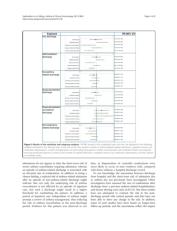

In [ ]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['file_name'])
print(I.shape)
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
print(img)

{'file_name': 'PMC3880050_00005.jpg', 'width': 596, 'id': 372844, 'height': 794}


[{'segmentation': [[0.511275167785235, 0.7159949622166247, 0.9035906040268455, 0.7159949622166247, 0.9035906040268455, 0.7311335012594459, 0.9036744966442953, 0.7311335012594459, 0.9036744966442953, 0.744874055415617, 0.8448657718120806, 0.744874055415617, 0.8448657718120806, 0.7599370277078086, 0.511275167785235, 0.7599370277078086, 0.511275167785235, 0.7461964735516373, 0.511275167785235, 0.7311335012594459, 0.511275167785235, 0.7159949622166247]], 'area': 7741.443669785978, 'iscrowd': 0, 'image_id': 372844, 'bbox': [0.511275167785235, 0.7159949622166247, 0.3923825503355705, 0.043954659949622166], 'category_id': 1, 'id': 3634000}, {'segmentation': [[0.09511744966442953, 0.7159949622166247, 0.4873993288590604, 0.7159949622166247, 0.4873993288590604, 0.7311335012594459, 0.48760067114093963, 0.7311335012594459, 0.48760067114093963, 0.7461964735516373, 0.48761744966442955, 0.7461964735516373, 0.48761744966442955, 0.7599496221662468, 0.4873657718120806, 0.7599496221662468, 0.4873657718120

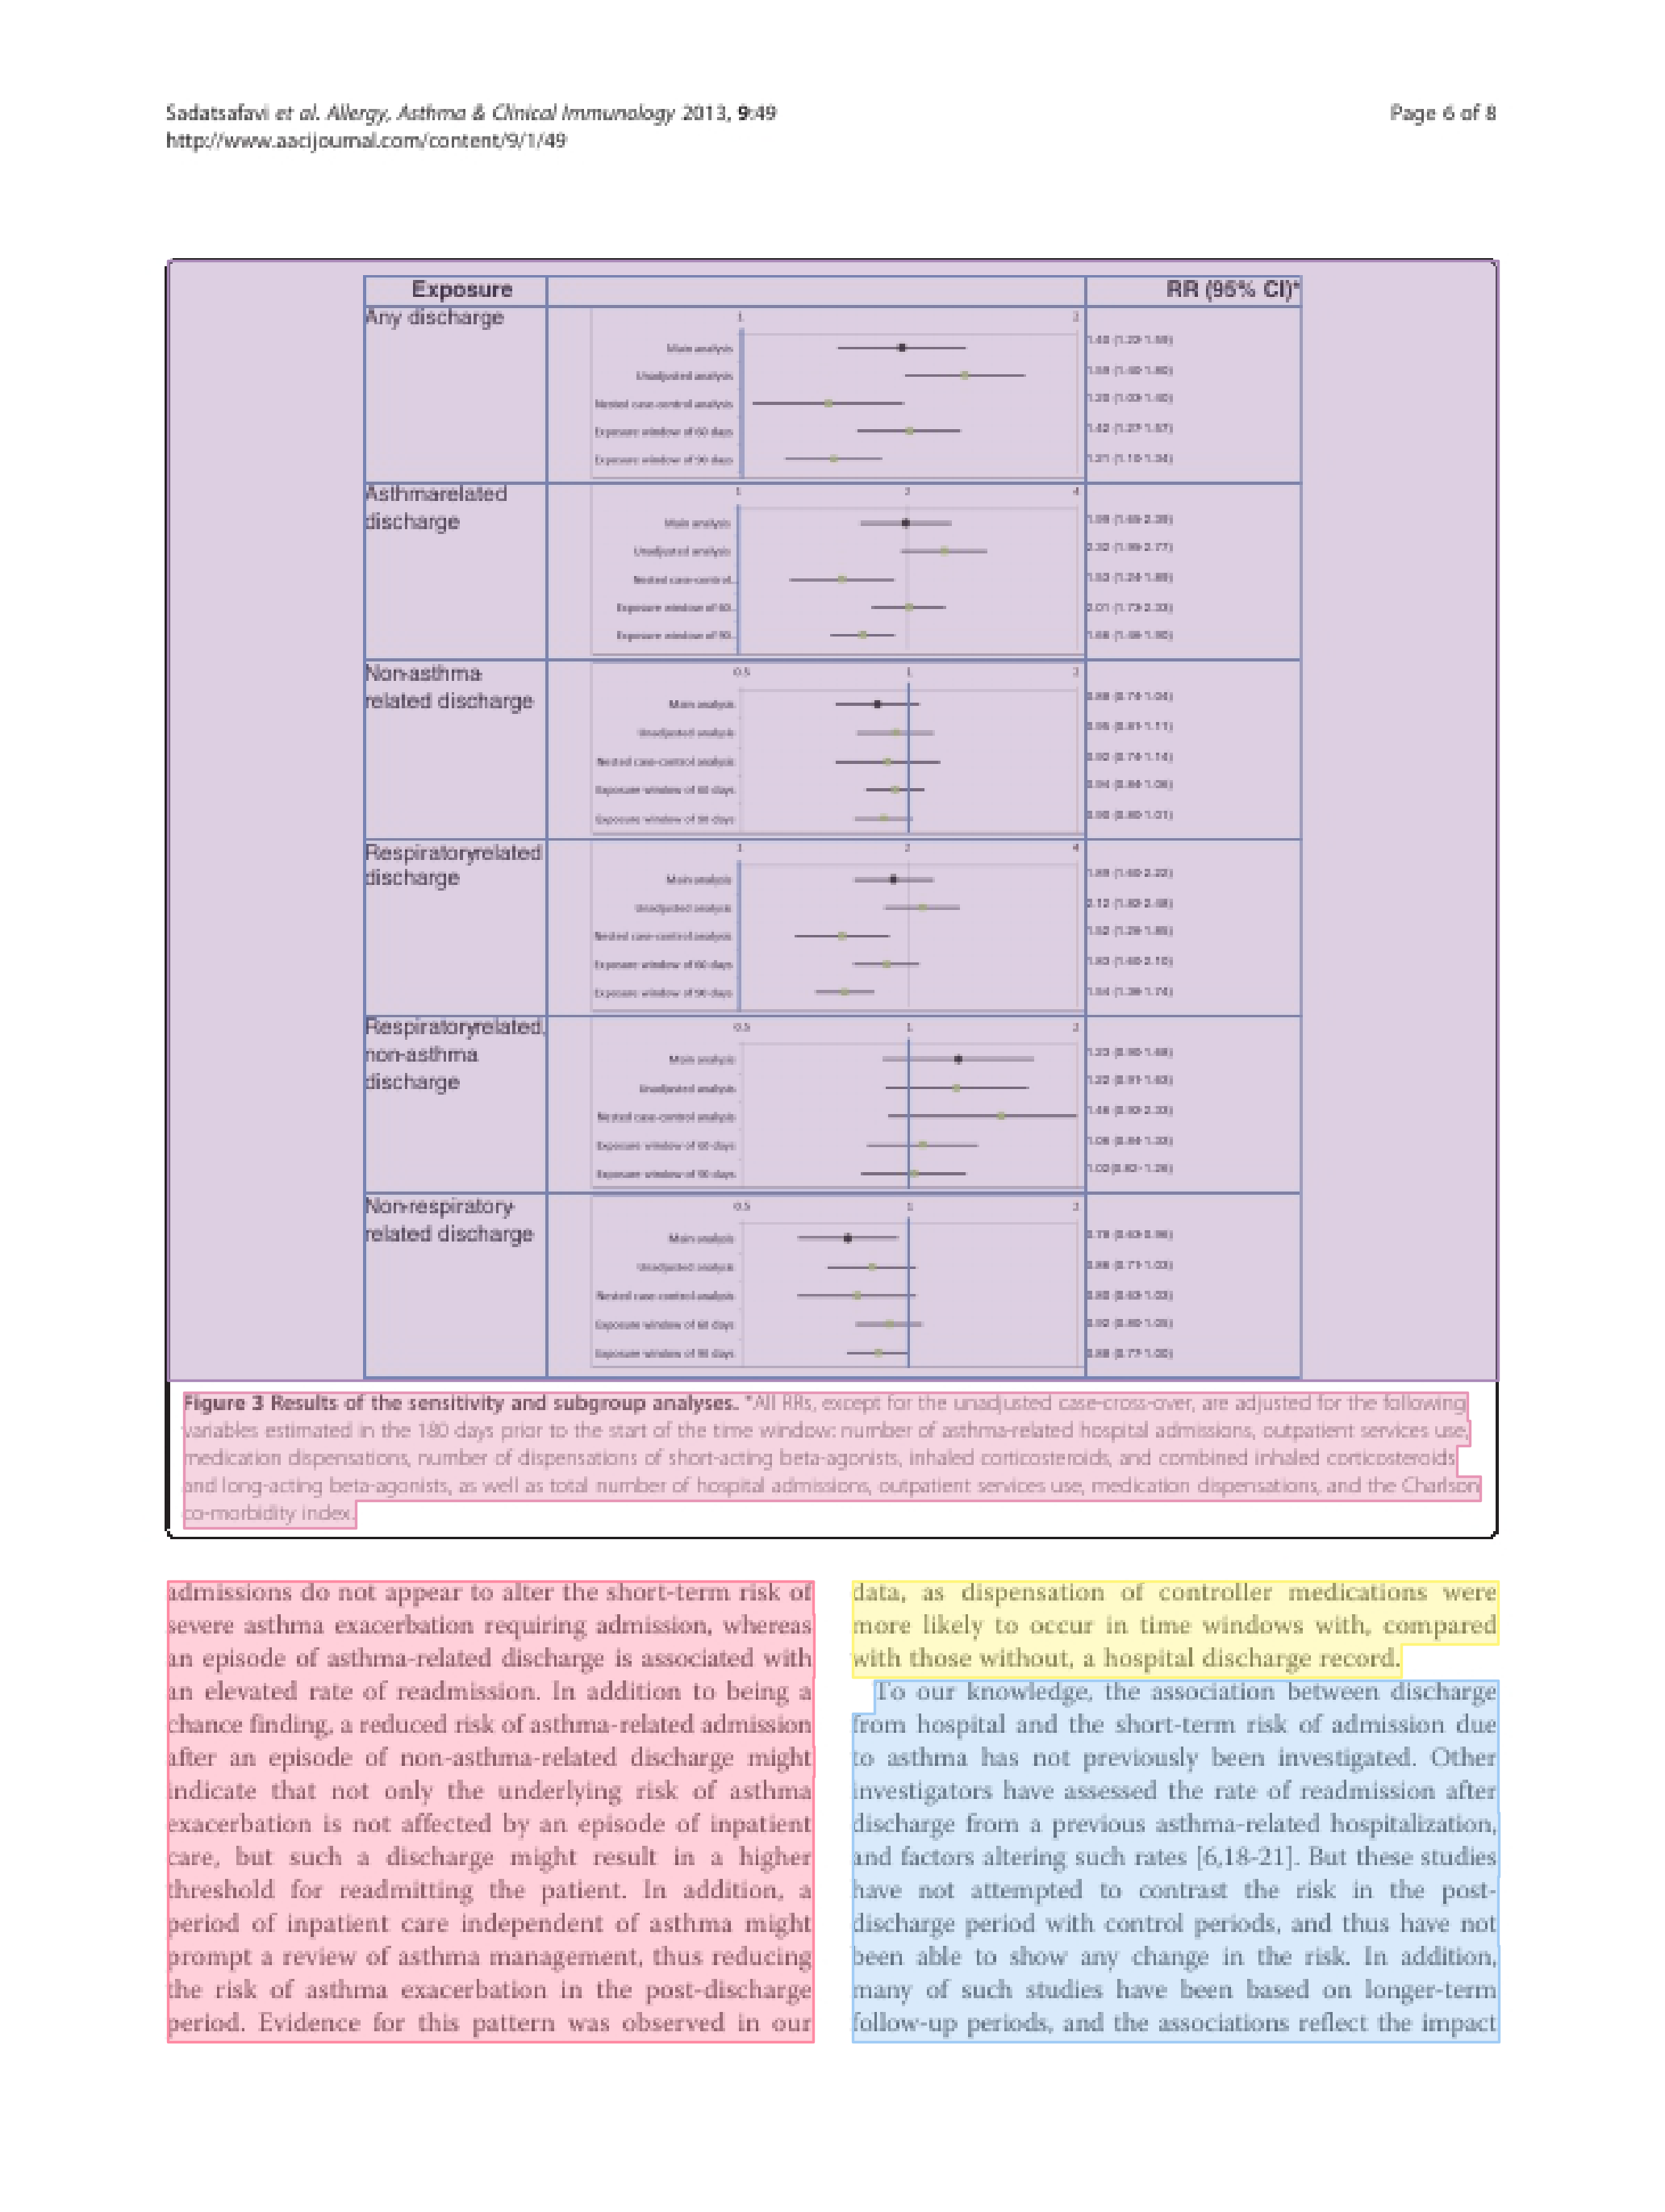

In [ ]:
# load and display instance annotations
plt.figure(figsize=(30, 30), dpi=120)
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
h = I.shape[0]
w = I.shape[1]
print(anns)
for i in range(len(anns)):
    anns[i]['segmentation'][0] = np.array(anns[i]['segmentation'][0]) * np.array([w, h] * int(len(anns[i]['segmentation'][0])/2))
#print(anns[0])
#anns_new = np.array(anns[]) * np.array([h, w] * int(len(anns)/2))
coco.showAnns(anns)

In [ ]:
print(anns)

[{'segmentation': [array([304.72, 568.5 , 538.54, 568.5 , 538.54, 580.52, 538.59, 580.52,
       538.59, 591.43, 503.54, 591.43, 503.54, 603.39, 304.72, 603.39,
       304.72, 592.48, 304.72, 580.52, 304.72, 568.5 ])], 'area': 7741.443669785978, 'iscrowd': 0, 'image_id': 372844, 'bbox': [0.511275167785235, 0.7159949622166247, 0.3923825503355705, 0.043954659949622166], 'category_id': 1, 'id': 3634000}, {'segmentation': [array([ 56.69, 568.5 , 290.49, 568.5 , 290.49, 580.52, 290.61, 580.52,
       290.61, 592.48, 290.62, 592.48, 290.62, 603.4 , 290.47, 603.4 ,
       290.47, 616.52, 290.52, 616.52, 290.52, 628.48, 290.62, 628.48,
       290.62, 639.4 , 290.52, 639.4 , 290.52, 652.52, 290.55, 652.52,
       290.55, 663.43, 290.5 , 663.43, 290.5 , 675.4 , 290.49, 675.4 ,
       290.49, 688.52, 290.56, 688.52, 290.56, 699.43, 290.54, 699.43,
       290.54, 711.39, 290.51, 711.39, 290.51, 724.51, 290.52, 724.51,
       290.52, 735.43,  56.69, 735.43,  56.69, 724.51,  56.69, 712.5 ,
        5

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])

In [ ]:
print(img)

[{'file_name': 'PMC3259476_00009.jpg', 'width': 601, 'id': 406876, 'height': 792}]


#Создаем функции для обучения модели, классы датасетов и класс модели на основе .DeepLabV3 (backbone Resnet101), трансформации

In [ ]:
import glob
from pycocotools.coco import COCO
import more_itertools as mit

class LayoutDataset(Dataset):
    def __init__(self, root, transforms, json_file):
        super(LayoutDataset, self).__init__()
        self.root = root 
        self.catNms = ['text','figure']
        self.coco=COCO(os.path.join(root, json_file))
        self.catIds = self.coco.getCatIds(catNms=['text','figure']);
        imgIds = self.coco.getImgIds(catIds=self.catIds);
        self.imgs =  self.coco.loadImgs(imgIds)
        self.transforms = transforms
        self.json_file = json_file
  
    def __getitem__(self, idx):
        
        sample = {}
        img = self.imgs[idx]
        filename = os.path.join(self.root , "data/" + self.imgs[idx]['file_name'])
        #print(filename)
        #print(self.image_names[idx])
        image = cv2.imread(filename)
        # if image == None:
        #    print("None")
        #print(self.image_names[idx])
        #print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image)
        sample["image"] = image
        #print(image.shape)
        h = image.shape[0]
        w = image.shape[1]
        #plt.imshow(image)
        #plt.show()
        for s, catId in enumerate(self.catIds):
            annIds = self.coco.getAnnIds(imgIds=img['id'], catIds=[catId], iscrowd=None)
            anns = self.coco.loadAnns(annIds)
            h = image.shape[0]
            w = image.shape[1]
            #print(anns)
            mask = np.zeros(shape=image.shape[:2])
            mask_boxes = np.zeros(shape=image.shape[:2])
            #boxes = []          
            for i in range(len(anns)):
                npoints = int(len(anns[i]['segmentation'][0])/2)
                if self.json_file == 'train.json':
                   poly = np.array(anns[i]['segmentation'][0]) * np.array([w, h] * npoints)
                   
                else:
                   poly = np.array(anns[i]['segmentation'][0])
                #box =  np.array(anns[i]['bbox']) * np.array([w, h] * 2)  
                # xmin = min(box[0], box[2])
                # xmax = max(box[0], box[2])
                # ymin = min(box[1], box[3])
                # ymax = max(box[1], box[3])
                xmin = min(poly[::2])
                xmax = max(poly[::2])
                ymin = min(poly[1::2])
                ymax = max(poly[1::2])
                box = [xmin, ymin, xmin, ymax, xmax, ymax, xmax, ymin] 
                points_box = np.array(list((mit.chunked(box, 2)))).astype(int) 
                #print(points_box)
                points = np.array(list((mit.chunked(poly, 2)))).astype(int)
                #boxes.append(box)
                #points = np.array_split(poly, npoints)
                #print(points)
                #points = np.array([[1, 2], [3, 4]])
                cv2.fillConvexPoly(mask_boxes, points_box, 255)
                cv2.fillConvexPoly(mask, points, 255)
            #plt.imshow(mask)
            #plt.show()
            mask = (mask.astype(np.float32)/255.0) > 0.5
            mask_boxes = (mask_boxes.astype(np.float32)/255.0) > 0.5
            #plt.imshow(mask)
            #plt.show()
            if s == 0:
              masks = mask.reshape(1, h, w)
              masks_boxes = mask_boxes.reshape(1, h, w)
            else:
              masks = np.concatenate((masks, mask.reshape(1, h, w)), axis = 0)
              masks_boxes = np.concatenate((masks_boxes, mask_boxes.reshape(1, h, w)), axis = 0)
            #cv2.imwrite( filename + "_" + self.catNms[s], mask)  
        
        sample['mask'] = masks
        sample['image'] = image
        sample['boxes'] = masks_boxes
        if self.transforms is not None:
             sample = self.transforms(sample)

          
        return sample['image'], sample['mask'], sample['image_cropped'], sample['boxes']
        #return image

    def __len__(self):
        return len(self.imgs)

In [ ]:
CROP_SIZE = 256

In [ ]:
class ScaleMaxSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        # self.size = torch.tensor(size, dtype=torch.float)
        self.size = np.asarray(size, dtype=np.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h < w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        interpolation = cv2.INTER_AREA if f <= 1 else cv2.INTER_LINEAR
        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=interpolation)
        masks_resized = []
        masks_boxes_resized = []
        for i in range(2):
           mask = sample['mask'][i].astype('float32')
           #print(mask.shape)
           mask = cv2.resize(mask, None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
           masks_resized.append(mask)
           mask_boxes = sample['boxes'][i].astype('float32')
           #print(mask.shape)
           mask_boxes = cv2.resize(mask_boxes, None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
           masks_boxes_resized.append(mask_boxes)
        sample['boxes'] = np.array(masks_boxes_resized)
        sample['mask'] = np.array(masks_resized)
        #sample['boxes'] = np.array(sample['boxes']).astype(np.float32) * f
        
           
        #print(sample['mask'].shape)   
        #sample["scale_coef"] = f

       

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name].copy()
        #print(type(img[0, 0, 0]))
        mask = sample['mask'].copy()
        mask_boxes = sample['boxes'].copy()
        h, w, _ = img.shape
        margin_h = (self.size - h) // 2
        margin_w = (self.size - w) // 2
        sample[self.elem_name] = np.full((CROP_SIZE, CROP_SIZE, 3), 255, np.uint8)
        sample[self.elem_name][margin_h:margin_h + h, margin_w:margin_w + w] = img
        sample['mask'] = np.zeros((2, CROP_SIZE, CROP_SIZE), np.float32)
        sample['mask'][:, margin_h:margin_h + h, margin_w:margin_w + w] = mask
        sample['boxes'] = np.zeros((2, CROP_SIZE, CROP_SIZE), np.float32)
        sample['boxes'][:, margin_h:margin_h + h, margin_w:margin_w + w] = mask_boxes
        #print(sample['mask'].shape)
       # sample["crop_margin_x"] = margin_w
       # sample["crop_margin_y"] = margin_h
        sample['image_cropped'] = torch.LongTensor(sample[self.elem_name].copy())
        # for i in range(len(sample['boxes'])):
        #     sample['boxes'][i][0] += margin_w
        #     sample['boxes'][i][2] += margin_w
        #     sample['boxes'][i][1] += margin_h
        #     sample['boxes'][i][3] += margin_h
            

    
        return sample
        
class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        #print(sample['mask'].shape)     
        #print(sample['image']) 
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])
        #print(sample['mask'].shape)     
        #print(sample['image'])      

        return sample

In [ ]:
from torchvision import transforms
import albumentations


class apply_albumentations(object):
    def __init__(self, augmenter):
        self.augmenter = augmenter


    def __call__(self, sample):
        #print(sample)
        #print(self.augmenter)
        sample['image'] = self.augmenter(image=np.array(sample['image']))["image"]
        #plt.imshow(sample['image'])
        return sample

augmenter = albumentations.Compose([
    #albumentations.ShiftScaleRotate(rotate_limit=90, p=0.7),
    #albumentations.RandomBrightnessContrast(p=0.4),
    # albumentations.RandomGamma(p=0.4),
    # albumentations.Blur(blur_limit=2, p=0.1),
    #albumentations.GaussNoise((10, 100), p=0.2),
    albumentations.HorizontalFlip(p=0.5)
])


train_transforms = transforms.Compose([
        #apply_albumentations(augmenter),                                
        ScaleMaxSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        #TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),#
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",))
])

val_transforms = transforms.Compose([
                                
        ScaleMaxSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        #TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),#
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",))
])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
import segmentation_models_pytorch as smp
def get_model():
    
    model = smp.DeepLabV3(encoder_name='resnet101', encoder_depth=5, encoder_weights='imagenet', decoder_channels=256, in_channels=3, classes=2, activation=None, upsampling=8, aux_params=None) 
    
    return model

In [ ]:

def dice_coeff(input, target):
    smooth = 1.

    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    union = input_flat.sum() + target_flat.sum()

    return (2. * intersection + smooth) / (union + smooth)

def  jaccard_coeff(input, target):
    smooth = 1.

    input_flat = input.reshape(-1)
    target_flat = target.reshape(-1)
    intersection = (input_flat * target_flat).sum()
    union = input_flat.sum() + target_flat.sum()

    return (intersection + smooth) / (union - intersection + smooth)    



def jaccard_loss(input, target):
    
   return -torch.log(jaccard_coeff(input[:, 0, :, :], target[:, 0, :, :])) - torch.log(jaccard_coeff(input[:, 1, :, :], target[:, 1, :, :]))     




In [ ]:

import logging
import cv2
import numpy as np
import torch


def get_logger(filename: str) -> logging.Logger:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s %(message)s', '%Y-%m-%d %H:%M:%S')
    fh = logging.FileHandler(filename)
    fh.setLevel(logging.INFO)
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    sh = logging.StreamHandler()
    sh.setLevel(logging.INFO)
    sh.setFormatter(formatter)
    logger.addHandler(sh)
    return logger




In [ ]:
def get_consistancy_loss(masks_probs, boxes):
    TRESHOLD_MASK = 0.5
    loss = 0.0
    for i in range(boxes.shape[0]):
      for j in range(boxes.shape[1]):
         #print(input[i, j].sum())
         contours,_ = cv2.findContours((boxes[i, j] > TRESHOLD_MASK).astype(np.uint8), 1, 1)
         #print(len(contours))
         for s in range(len(contours)):
           xmin = min(contours[s][:, 0, 0])
           xmax = max(contours[s][:, 0, 0])
           ymin = min(contours[s][:, 0, 1])
           ymax = max(contours[s][:, 0, 1])
           #print([xmin, xmax, ymin, ymax])
           temp = masks_probs[i, j, ymin:ymax, xmin:xmax] 
           pmean = temp.mean()
           loss += ((temp  - pmean)**2).sum()/ ((xmax - xmin) * (ymax - ymin))
           #print(pmean, loss)
           #print(contours[i])
    return loss  
           
 

In [ ]:

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#os.chdir("/content/")





def validate(model, val_dataloader, device):
    model.eval().to(device)
    val_dice = []
    #val_iou = []
    val_jaccard = []
    for batch in tqdm(val_dataloader):
        images, true_masks, _ , _= batch
        with torch.no_grad():
            masks_pred = model(images.to(device)).squeeze(1)  # (b, 1, h, w) -> (b, h, w)
        masks_pred = (torch.sigmoid(masks_pred) > 0.5).float() #* 255
     
        dice = dice_coeff(masks_pred.cpu(), true_masks).item()
        val_dice.append(dice)
        #iou = iou_per_class(masks_pred.cpu(), true_masks.long())
        #val_iou.append(iou.numpy())
        val_jaccard.append((jaccard_coeff(masks_pred.cpu()[:, 0, :, :],true_masks[:, 0, :, :]), jaccard_coeff(masks_pred.cpu()[:, 1, :, :],true_masks[:, 1, :, :]) ))
    return np.mean(val_dice),  np.mean(val_jaccard, axis = 0)


def train(model, optimizer, criterion, scheduler, train_dataloader, logger, cl = False, device=None):
    model.train()

    epoch_losses = []
    epoch_bce_losses, epoch_dice_losses, const_loss = [], [], []

    history = []
    tqdm_iter = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, batch in tqdm_iter:
        imgs, true_masks, _, boxes = batch
        #print(imgs.shape)
        #print(true_masks.shape)
        masks_pred = model(imgs.to(device))
        #print(masks_pred)
        #masks_probs = torch.sigmoid(masks_pred['out'])
        masks_probs = torch.sigmoid(masks_pred)
        #print(masks_probs.shape)
        #print(true_masks.shape)
  
        #bce_loss_value, jaccard_loss_value = criterion(masks_probs.cpu().view(-1), true_masks.view(-1))
        bce_loss_value = criterion[0](masks_probs.cpu().view(-1), true_masks.view(-1))
        jaccard_loss_value = criterion[1](masks_probs.cpu(), true_masks)
        if cl:
            consistency_loss =  get_consistancy_loss(masks_probs.cpu(), boxes.numpy())
        #print(consistency_loss)
        # temp = masks_probs.cpu().view(-1)
        # #print(temp.shape)
        # pmean = temp[boxes.bool().view(-1)].mean()
        # #print(pmean)
        # #print(temp[boxes.bool().view(-1)].shape)
        # consistency_loss = ((temp[boxes.bool().view(-1)] - pmean)**2).sum()/(boxes.bool().view(-1)).sum()
        # #loss = bce_loss_value + dice_loss_value + consistency_loss
        loss = bce_loss_value + jaccard_loss_value
        if cl:
            loss += consistency_loss

        #print(loss.cpu())
        epoch_bce_losses.append(bce_loss_value.item())
        #epoch_dice_losses.append(dice_loss_value.item())
        epoch_dice_losses.append(jaccard_loss_value.item())
        if cl:
            const_loss.append(consistency_loss.item())
        epoch_losses.append(loss.item())
        tqdm_iter.set_description(f"mean loss: {np.mean(epoch_losses):.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #if scheduler is not None:
         #   scheduler.step(loss.item())

        history.append(loss.cpu().data.numpy())
    
        

    if cl:
        logger.info(
           f"Epoch finished! Loss: {np.mean(epoch_losses):.5f} ({np.mean(epoch_bce_losses):.5f} | {np.mean(epoch_dice_losses):.5f} | {np.mean(const_loss):.5f})")
    else:
        logger.info(
           f"Epoch finished! Loss: {np.mean(epoch_losses):.5f} ({np.mean(epoch_bce_losses):.5f} | {np.mean(epoch_dice_losses):.5f})")
    

        

    return np.mean(epoch_losses)


   

#Задаем гиперпараметры, создаем датасеты и модель

In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.epochs = 2
    self.batch_size = 16
    self.lr= 3e-4
    self.weight_decay= 0#1e-6
    self.learning_rate_gamma=None
    self.image_size = 256
    self.weight_bce=0.7
    self.load=None
    self.gpu = True
    self.output_dir="/content/drive/MyDrive/MADE/work/mil_team/models"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

In [ ]:
os.makedirs(args.output_dir, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

logger = get_logger(os.path.join(args.output_dir, "train.log"))
logger.info("Start training with params:")
for arg, value in sorted(vars(args).items()):
    logger.info("Argument %s: %r", arg, value)

# TODO TIP: Try other models, either from smp package or from somewhere else.
model = get_model()
#print(model)
if args.load is not None:
    with open(args.load, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

model.requires_grad_(True)

for param in model.parameters():
  param.requires_grad = True
for param in model.segmentation_head.parameters():
  param.requires_grad = True

model.segmentation_head.apply(initialize_weights)  
model.to(device)
logger.info(f"Model type: {model.__class__.__name__}")

optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


#criterion1 = lambda x, y: (args.weight_bce * torchvision.ops.sigmoid_focal_loss(x, y, reduction = 'mean'))
criterion1 = lambda x, y: (args.weight_bce * nn.BCELoss()(x, y))
#criterion2 = lambda x, y:(1. - args.weight_bce) * smp.losses.JaccardLoss(mode= 'binary', from_logits = False)(x, y)#lambda x, y: (1. - args.weight_bce) * dice_loss(x, y)
criterion2 = lambda x, y:(1. - args.weight_bce) * jaccard_loss(x, y)#lambda x, y: (1. - args.weight_bce) * dice_loss(x, y)
criterion = (criterion1, criterion2)
#criterion = lambda x, y: (args.weight_bce * nn.BCELoss()(x, y), (1. - args.weight_bce) * jaccard_loss(x, y))



train_dataset = LayoutDataset('/content/datadir/',  train_transforms, "train.json")
val_dataset = LayoutDataset('/content/datadir/', val_transforms, "test.json")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True)#,worker_init_fn=seed_worker,   generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                            pin_memory=True, shuffle=False, drop_last=False)#, worker_init_fn=seed_worker,   generator=g,)

logger.info(f"Length of train / val = {len(train_dataset)} / {len(val_dataset)}")
logger.info(f"Number of batches of train / val = {len(train_dataloader)} / {len(val_dataloader)}")

best_model_info = {"epoch": -1, "val_dice": 0., "train_dice": 0., "train_loss": 0.}




2022-05-02 21:47:56 Start training with params:
2022-05-02 21:47:56 Argument batch_size: 16
2022-05-02 21:47:56 Argument data_dir: './data_preprocessed_python/'
2022-05-02 21:47:56 Argument epochs: 2
2022-05-02 21:47:56 Argument gpu: True
2022-05-02 21:47:56 Argument image_size: 256
2022-05-02 21:47:56 Argument learning_rate_gamma: None
2022-05-02 21:47:56 Argument load: None
2022-05-02 21:47:56 Argument lr: 0.0003
2022-05-02 21:47:56 Argument output_dir: '/content/drive/MyDrive/MADE/work/mil_team/models'
2022-05-02 21:47:56 Argument weight_bce: 0.7
2022-05-02 21:47:56 Argument weight_decay: 0
2022-05-02 21:48:01 Model type: DeepLabV3


loading annotations into memory...


2022-05-02 21:48:02 Length of train / val = 859 / 170
2022-05-02 21:48:02 Number of batches of train / val = 53 / 11


Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
args.epochs = 40
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
for epoch in range(args.epochs):
    logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")

    train_loss = train(model, optimizer, criterion, scheduler, train_dataloader, logger, False, device)
    print(train_loss)
    val_dice = validate(model, val_dataloader, device)
    print(val_dice)
    scheduler.step(train_loss)
    if val_dice[0] > best_model_info["val_dice"]:
        best_model_info["val_dice"] = val_dice[0]
        best_model_info["train_loss"] = train_loss

        best_model_info["epoch"] = epoch
        with open(os.path.join(args.output_dir, "CP-best_seg.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.3f} (best)")
    else:
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.5f} (best {best_model_info['val_dice']:.5f})")

with open(os.path.join(args.output_dir, "CP-last_seg.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)



2022-05-02 21:01:46 Starting epoch 1/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:03:45 Epoch finished! Loss: 0.42229 (0.18962 | 0.23267)


0.42228818530181667


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9217034199021079, array([0.8330438, 0.8684765], dtype=float32))


2022-05-02 21:03:53 Validation Dice Coeff: 0.922 (best)
2022-05-02 21:03:53 Starting epoch 2/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:05:51 Epoch finished! Loss: 0.18539 (0.07133 | 0.11405)


0.1853858617679128


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9379660270430825, array([0.8829598, 0.8819943], dtype=float32))


2022-05-02 21:05:58 Validation Dice Coeff: 0.938 (best)
2022-05-02 21:05:58 Starting epoch 3/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:07:58 Epoch finished! Loss: 0.14318 (0.05306 | 0.09012)


0.14318058822514876


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9480036876418374, array([0.89256483, 0.90564823], dtype=float32))


2022-05-02 21:08:05 Validation Dice Coeff: 0.948 (best)
2022-05-02 21:08:05 Starting epoch 4/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:10:04 Epoch finished! Loss: 0.11474 (0.04056 | 0.07418)


0.11474067549098213


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9503998593850569, array([0.9026053, 0.9060589], dtype=float32))


2022-05-02 21:10:11 Validation Dice Coeff: 0.950 (best)
2022-05-02 21:10:11 Starting epoch 5/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:12:10 Epoch finished! Loss: 0.10095 (0.03434 | 0.06661)


0.1009462927028818


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9563723965124651, array([0.9125604, 0.9170141], dtype=float32))


2022-05-02 21:12:17 Validation Dice Coeff: 0.956 (best)
2022-05-02 21:12:17 Starting epoch 6/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:14:15 Epoch finished! Loss: 0.09283 (0.03041 | 0.06242)


0.09282601765304241


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:14:22 Validation Dice Coeff: 0.94746 (best 0.95637)
2022-05-02 21:14:22 Starting epoch 7/40.


(0.9474622011184692, array([0.9052894, 0.8958317], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:16:20 Epoch finished! Loss: 0.08726 (0.02813 | 0.05913)


0.08725892499370395


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:16:27 Validation Dice Coeff: 0.95615 (best 0.95637)
2022-05-02 21:16:27 Starting epoch 8/40.


(0.9561450806531039, array([0.9179952 , 0.91309774], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:18:25 Epoch finished! Loss: 0.07778 (0.02406 | 0.05372)


0.07778228664735579


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9593504504723982, array([0.9160149, 0.9249119], dtype=float32))


2022-05-02 21:18:33 Validation Dice Coeff: 0.959 (best)
2022-05-02 21:18:33 Starting epoch 9/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:20:31 Epoch finished! Loss: 0.07294 (0.02244 | 0.05050)


0.07294043701774669


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9616739424792203, array([0.9208923, 0.928612 ], dtype=float32))


2022-05-02 21:20:39 Validation Dice Coeff: 0.962 (best)
2022-05-02 21:20:39 Starting epoch 10/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:22:37 Epoch finished! Loss: 0.06854 (0.02062 | 0.04792)


0.06853943015888052


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:22:44 Validation Dice Coeff: 0.96040 (best 0.96167)
2022-05-02 21:22:44 Starting epoch 11/40.


(0.9604006084528837, array([0.92173535, 0.92394966], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:24:42 Epoch finished! Loss: 0.06597 (0.01997 | 0.04600)


0.06596632090941915


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:24:49 Validation Dice Coeff: 0.96142 (best 0.96167)
2022-05-02 21:24:49 Starting epoch 12/40.


(0.9614150903441689, array([0.9259495 , 0.92453253], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:26:49 Epoch finished! Loss: 0.06253 (0.01872 | 0.04381)


0.06252873492128444


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9631574153900146, array([0.9271631, 0.9289348], dtype=float32))


2022-05-02 21:26:56 Validation Dice Coeff: 0.963 (best)
2022-05-02 21:26:56 Starting epoch 13/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:28:54 Epoch finished! Loss: 0.05978 (0.01776 | 0.04202)


0.05977747399570807


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9631826498291709, array([0.92746794, 0.9287684 ], dtype=float32))


2022-05-02 21:29:02 Validation Dice Coeff: 0.963 (best)
2022-05-02 21:29:02 Starting epoch 14/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:31:00 Epoch finished! Loss: 0.05770 (0.01701 | 0.04069)


0.057699016875253535


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:31:07 Validation Dice Coeff: 0.96295 (best 0.96318)
2022-05-02 21:31:07 Starting epoch 15/40.


(0.9629497582262213, array([0.92867893, 0.92757547], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:33:05 Epoch finished! Loss: 0.05701 (0.01687 | 0.04014)


0.05701111917788128


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9633866656910289, array([0.9281593 , 0.92910993], dtype=float32))


2022-05-02 21:33:13 Validation Dice Coeff: 0.963 (best)
2022-05-02 21:33:13 Starting epoch 16/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:35:11 Epoch finished! Loss: 0.05533 (0.01648 | 0.03885)


0.05533082094394936


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:35:18 Validation Dice Coeff: 0.96294 (best 0.96339)
2022-05-02 21:35:18 Starting epoch 17/40.


(0.9629386338320646, array([0.9298983, 0.926617 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:37:16 Epoch finished! Loss: 0.05324 (0.01579 | 0.03745)


0.053242517600082


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9640783721750433, array([0.92901826, 0.9306188 ], dtype=float32))


2022-05-02 21:37:24 Validation Dice Coeff: 0.964 (best)
2022-05-02 21:37:24 Starting epoch 18/40.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:39:22 Epoch finished! Loss: 0.05652 (0.01754 | 0.03898)


0.05651911917441296


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:39:29 Validation Dice Coeff: 0.96133 (best 0.96408)
2022-05-02 21:39:29 Starting epoch 19/40.


(0.9613287340510975, array([0.92880476, 0.9222184 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:41:27 Epoch finished! Loss: 0.05882 (0.01881 | 0.04001)


0.05882176588166435


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:41:34 Validation Dice Coeff: 0.95332 (best 0.96408)
2022-05-02 21:41:34 Starting epoch 20/40.


(0.9533151225610212, array([0.9240986, 0.9008919], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model_state  = torch.load( os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", f"CP-best_seg.pth"))
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=args.weight_decay)
args.epochs = 8
for epoch in range(args.epochs):
    logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")

    train_loss = train(model, optimizer, criterion, scheduler, train_dataloader, logger, False, device)
    print(train_loss)
    val_dice = validate(model, val_dataloader, device)
    print(val_dice)
    scheduler.step(train_loss)
    if val_dice[0] > best_model_info["val_dice"]:
        best_model_info["val_dice"] = val_dice[0]
        best_model_info["train_loss"] = train_loss
        best_model_info["epoch"] = epoch
        with open(os.path.join(args.output_dir, "CP-best_seg.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.3f} (best)")
    else:
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.5f} (best {best_model_info['val_dice']:.5f})")

with open(os.path.join(args.output_dir, "CP-last_seg.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)

2022-05-02 21:48:19 Starting epoch 1/8.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:50:18 Epoch finished! Loss: 0.05331 (0.01602 | 0.03729)


0.05330750957693694


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9639081358909607, array([0.9290419, 0.9301323], dtype=float32))


2022-05-02 21:50:26 Validation Dice Coeff: 0.964 (best)
2022-05-02 21:50:26 Starting epoch 2/8.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:52:24 Epoch finished! Loss: 0.05132 (0.01539 | 0.03593)


0.05132087488781731


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9645792787725275, array([0.93185884, 0.9305964 ], dtype=float32))


2022-05-02 21:52:32 Validation Dice Coeff: 0.965 (best)
2022-05-02 21:52:32 Starting epoch 3/8.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:54:30 Epoch finished! Loss: 0.05042 (0.01488 | 0.03554)


0.05042444774002399


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 21:54:37 Validation Dice Coeff: 0.96425 (best 0.96458)
2022-05-02 21:54:37 Starting epoch 4/8.


(0.9642469991337169, array([0.92617744, 0.9331085 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:56:35 Epoch finished! Loss: 0.04799 (0.01423 | 0.03376)


0.04798947295771455


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9648623466491699, array([0.93262   , 0.93088585], dtype=float32))


2022-05-02 21:56:43 Validation Dice Coeff: 0.965 (best)
2022-05-02 21:56:43 Starting epoch 5/8.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 21:58:41 Epoch finished! Loss: 0.04668 (0.01390 | 0.03278)


0.046679578721523285


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9664364077828147, array([0.933048  , 0.93549234], dtype=float32))


2022-05-02 21:58:48 Validation Dice Coeff: 0.966 (best)
2022-05-02 21:58:48 Starting epoch 6/8.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:00:47 Epoch finished! Loss: 0.04615 (0.01377 | 0.03238)


0.04614558464513635


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:00:53 Validation Dice Coeff: 0.96572 (best 0.96644)
2022-05-02 22:00:53 Starting epoch 7/8.


(0.965715619650754, array([0.9338881 , 0.93262553], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:02:51 Epoch finished! Loss: 0.04534 (0.01357 | 0.03177)


0.04533640963007819


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:02:58 Validation Dice Coeff: 0.96500 (best 0.96644)
2022-05-02 22:02:58 Starting epoch 8/8.


(0.9650021520527926, array([0.93260574, 0.93137586], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:04:56 Epoch finished! Loss: 0.04453 (0.01322 | 0.03131)


0.044533888334935566


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9670557162978433, array([0.93449134, 0.93670005], dtype=float32))


2022-05-02 22:05:04 Validation Dice Coeff: 0.967 (best)


In [ ]:
args.epochs = 5
for epoch in range(args.epochs):
    logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")

    train_loss = train(model, optimizer, criterion, scheduler, train_dataloader, logger, False, device)
    print(train_loss)
    val_dice = validate(model, val_dataloader, device)
    print(val_dice)
    scheduler.step(train_loss)
    if val_dice[0] > best_model_info["val_dice"]:
        best_model_info["val_dice"] = val_dice[0]
        best_model_info["train_loss"] = train_loss
        best_model_info["epoch"] = epoch
        with open(os.path.join(args.output_dir, "CP-best_seg.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.3f} (best)")
    else:
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.5f} (best {best_model_info['val_dice']:.5f})")

with open(os.path.join(args.output_dir, "CP-last_seg.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)

2022-05-02 22:05:43 Starting epoch 1/5.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:07:41 Epoch finished! Loss: 0.04367 (0.01302 | 0.03065)


0.043666614324979064


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:07:48 Validation Dice Coeff: 0.96646 (best 0.96706)
2022-05-02 22:07:48 Starting epoch 2/5.


(0.9664629318497397, array([0.93464017, 0.9347503 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:09:46 Epoch finished! Loss: 0.04398 (0.01318 | 0.03080)


0.04397941999277979


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:09:53 Validation Dice Coeff: 0.96553 (best 0.96706)
2022-05-02 22:09:53 Starting epoch 3/5.


(0.9655264290896329, array([0.9341233 , 0.93188137], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:11:51 Epoch finished! Loss: 0.04372 (0.01326 | 0.03046)


0.043718526737307604


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:11:58 Validation Dice Coeff: 0.96668 (best 0.96706)
2022-05-02 22:11:58 Starting epoch 4/5.


(0.9666798277334734, array([0.9353691, 0.9346022], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:13:56 Epoch finished! Loss: 0.04299 (0.01295 | 0.03004)


0.042988175069386104


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:14:03 Validation Dice Coeff: 0.96594 (best 0.96706)
2022-05-02 22:14:03 Starting epoch 5/5.


(0.9659354415806857, array([0.93494797, 0.9325214 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:16:01 Epoch finished! Loss: 0.04220 (0.01277 | 0.02943)


0.042198851072001005


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:16:08 Validation Dice Coeff: 0.96666 (best 0.96706)


(0.9666602719913829, array([0.9352802, 0.9349114], dtype=float32))


In [ ]:
model_state  = torch.load( os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", f"CP-best_seg.pth"))
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
args.epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=args.weight_decay)
for epoch in range(args.epochs):
    logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")

    train_loss = train(model, optimizer, criterion, scheduler, train_dataloader, logger, False, device)
    print(train_loss)
    val_dice = validate(model, val_dataloader, device)
    print(val_dice)
    scheduler.step(train_loss)
    if val_dice[0] > best_model_info["val_dice"]:
        best_model_info["val_dice"] = val_dice[0]
        best_model_info["train_loss"] = train_loss
        best_model_info["epoch"] = epoch
        with open(os.path.join(args.output_dir, "CP-best_seg.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.3f} (best)")
    else:
        logger.info(f"Validation Dice Coeff: {val_dice[0]:.5f} (best {best_model_info['val_dice']:.5f})")

with open(os.path.join(args.output_dir, "CP-last_seg.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)

2022-05-02 22:37:51 Starting epoch 1/10.


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:39:49 Epoch finished! Loss: 0.04068 (0.01190 | 0.02878)


0.0406779890071671


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:39:56 Validation Dice Coeff: 0.96772 (best 0.96782)
2022-05-02 22:39:56 Starting epoch 2/10.


(0.9677194248546254, array([0.9366572, 0.9371315], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:41:54 Epoch finished! Loss: 0.04039 (0.01183 | 0.02856)


0.040394137349893465


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:42:01 Validation Dice Coeff: 0.96780 (best 0.96782)
2022-05-02 22:42:01 Starting epoch 3/10.


(0.9678004275668751, array([0.93674225, 0.93733364], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:43:59 Epoch finished! Loss: 0.04027 (0.01180 | 0.02847)


0.040269049763117196


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:44:06 Validation Dice Coeff: 0.96753 (best 0.96782)
2022-05-02 22:44:06 Starting epoch 4/10.


(0.9675272486426614, array([0.93660426, 0.93656564], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:46:04 Epoch finished! Loss: 0.04033 (0.01180 | 0.02853)


0.040328495063871705


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:46:11 Validation Dice Coeff: 0.96767 (best 0.96782)
2022-05-02 22:46:11 Starting epoch 5/10.


(0.96767212044109, array([0.93672025, 0.9370045 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:48:09 Epoch finished! Loss: 0.04019 (0.01181 | 0.02838)


0.040188672126464126


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:48:16 Validation Dice Coeff: 0.96763 (best 0.96782)
2022-05-02 22:48:16 Starting epoch 6/10.


(0.9676274819807573, array([0.936575  , 0.93689656], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:50:14 Epoch finished! Loss: 0.03999 (0.01176 | 0.02823)


0.03998783294041202


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:50:21 Validation Dice Coeff: 0.96774 (best 0.96782)
2022-05-02 22:50:21 Starting epoch 7/10.


(0.9677437056194652, array([0.9369099, 0.937079 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:52:19 Epoch finished! Loss: 0.04007 (0.01173 | 0.02835)


0.040073996093475596


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:52:26 Validation Dice Coeff: 0.96748 (best 0.96782)
2022-05-02 22:52:26 Starting epoch 8/10.


(0.9674847722053528, array([0.9364262, 0.9365839], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:54:24 Epoch finished! Loss: 0.03975 (0.01169 | 0.02806)


0.03974843214986459


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:54:31 Validation Dice Coeff: 0.96758 (best 0.96782)
2022-05-02 22:54:31 Starting epoch 9/10.


(0.9675813100554727, array([0.93679136, 0.93665224], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:56:29 Epoch finished! Loss: 0.03994 (0.01174 | 0.02820)


0.03994133021190481


  0%|          | 0/11 [00:00<?, ?it/s]

2022-05-02 22:56:36 Validation Dice Coeff: 0.96767 (best 0.96782)
2022-05-02 22:56:36 Starting epoch 10/10.


(0.9676736105572094, array([0.93695664, 0.9367723 ], dtype=float32))


  0%|          | 0/53 [00:00<?, ?it/s]

2022-05-02 22:58:34 Epoch finished! Loss: 0.03984 (0.01171 | 0.02814)


0.03984334059762505


  0%|          | 0/11 [00:00<?, ?it/s]

(0.9678474502129988, array([0.9370821 , 0.93729436], dtype=float32))


2022-05-02 22:58:41 Validation Dice Coeff: 0.968 (best)


In [ ]:
torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", f"deap968_resnet11.pt")
            )   

In [ ]:
with open(os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", "deap968_resnet101_best.pth"), "wb") as fp:
    torch.save(model.state_dict(), fp)

#Достаем лучшую сохраненную модель и считаем jaccard index для каждого класса

In [ ]:
model = get_model()
model_state  = torch.load( os.path.join("/content/drive/MyDrive/MADE/work/mil_team/models/", f"deap968_resnet101_best.pth"))
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
train_dataset = LayoutDataset('/content/datadir/',  train_transforms, "train.json")
val_dataset = LayoutDataset('/content/datadir/', val_transforms, "test.json")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True)#,worker_init_fn=seed_worker,   generator=g,)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                            pin_memory=True, shuffle=False, drop_last=False)#, worker_init_fn=seed_worker,   generator=g,)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Для теста

In [ ]:
val_dice, val_jaccard = validate(model, val_dataloader, device)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
print(val_dice, val_jaccard)

0.9676672653718428 [0.9376642  0.93678784]


Для трейна

In [ ]:
train_dice,  train_jaccard = validate(model, train_dataloader, device)
print(train_dice, train_jaccard)

  0%|          | 0/53 [00:00<?, ?it/s]

0.9855526033437477 [0.9425431  0.99016285]


Рисуем картинки для теста и трейна.   
Для теста

  0%|          | 0/170 [00:00<?, ?it/s]

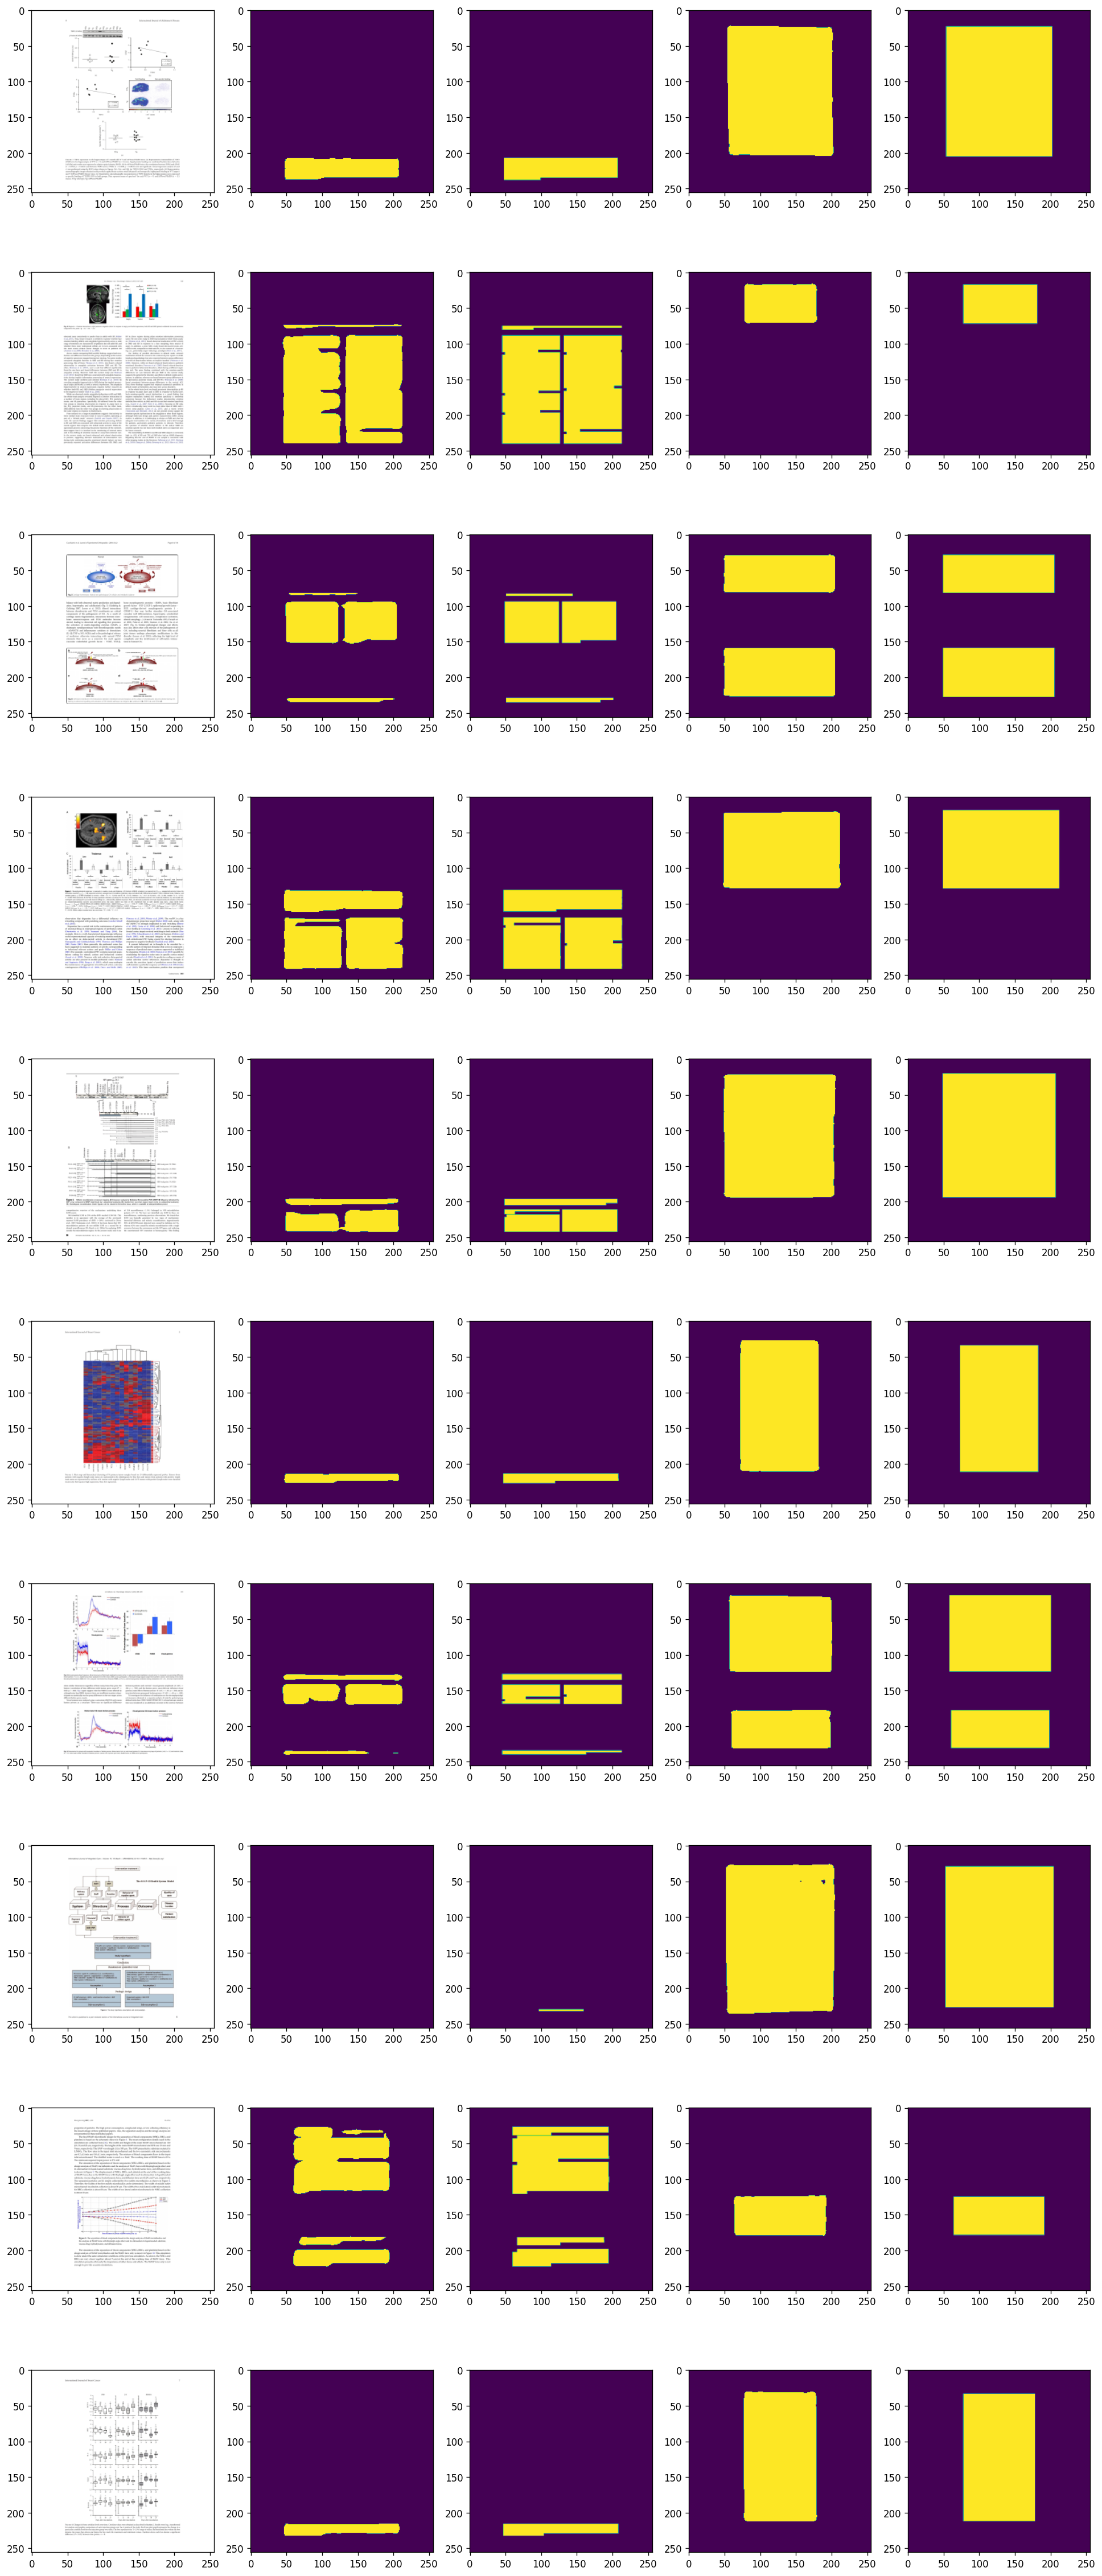

In [ ]:
val_dataloader1 = DataLoader(val_dataset, batch_size=1, num_workers=1,
                            pin_memory=True, shuffle=True, drop_last=False, worker_init_fn=seed_worker,   generator=g,)


def validate_draw(model, val_dataloader, device):
    model.eval().to(device)
   
    val_dice = []
    plt.figure(figsize=(20, 50), dpi=120)
    num_picts = 10
    s = 1
    #plt.subplots(1, 5)
    for i, batch in enumerate(tqdm(val_dataloader)):
        images, true_masks, image_cropped , boxes= batch
        with torch.no_grad():
            masks_pred = model(images.to(device)).squeeze(1)  # (b, 1, h, w) -> (b, h, w)
        masks_pred = (torch.sigmoid(masks_pred)> 0.9).float() #* 255
        #print(masks_pred.cpu().shape)

        plt.subplot(num_picts, 5, s)
        plt.imshow(image_cropped[0])
        s += 1
  
        plt.subplot(num_picts, 5, s)
        plt.imshow( masks_pred.cpu()[0][0] * 255)
        s += 1
        #plt.show()
        plt.subplot(num_picts, 5, s)
        plt.imshow( true_masks[0][0] * 255)
        s += 1
        #plt.show()
        plt.subplot(num_picts, 5, s)
        plt.imshow( masks_pred.cpu()[0][1] * 255)
        s += 1
        #plt.show()
        plt.subplot(num_picts, 5, s)
        plt.imshow( true_masks[0][1] * 255)
        s += 1
        #plt.show()
        # plt.imshow(boxes[0][1] * 255)
        # plt.show()
        # plt.imshow(boxes[0][0] * 255)
        # plt.show()
        if i >= num_picts - 1:
             break
    #return np.mean(val_dice)
validate_draw(model, val_dataloader1, device)    
  

Для трейна

  0%|          | 0/859 [00:00<?, ?it/s]

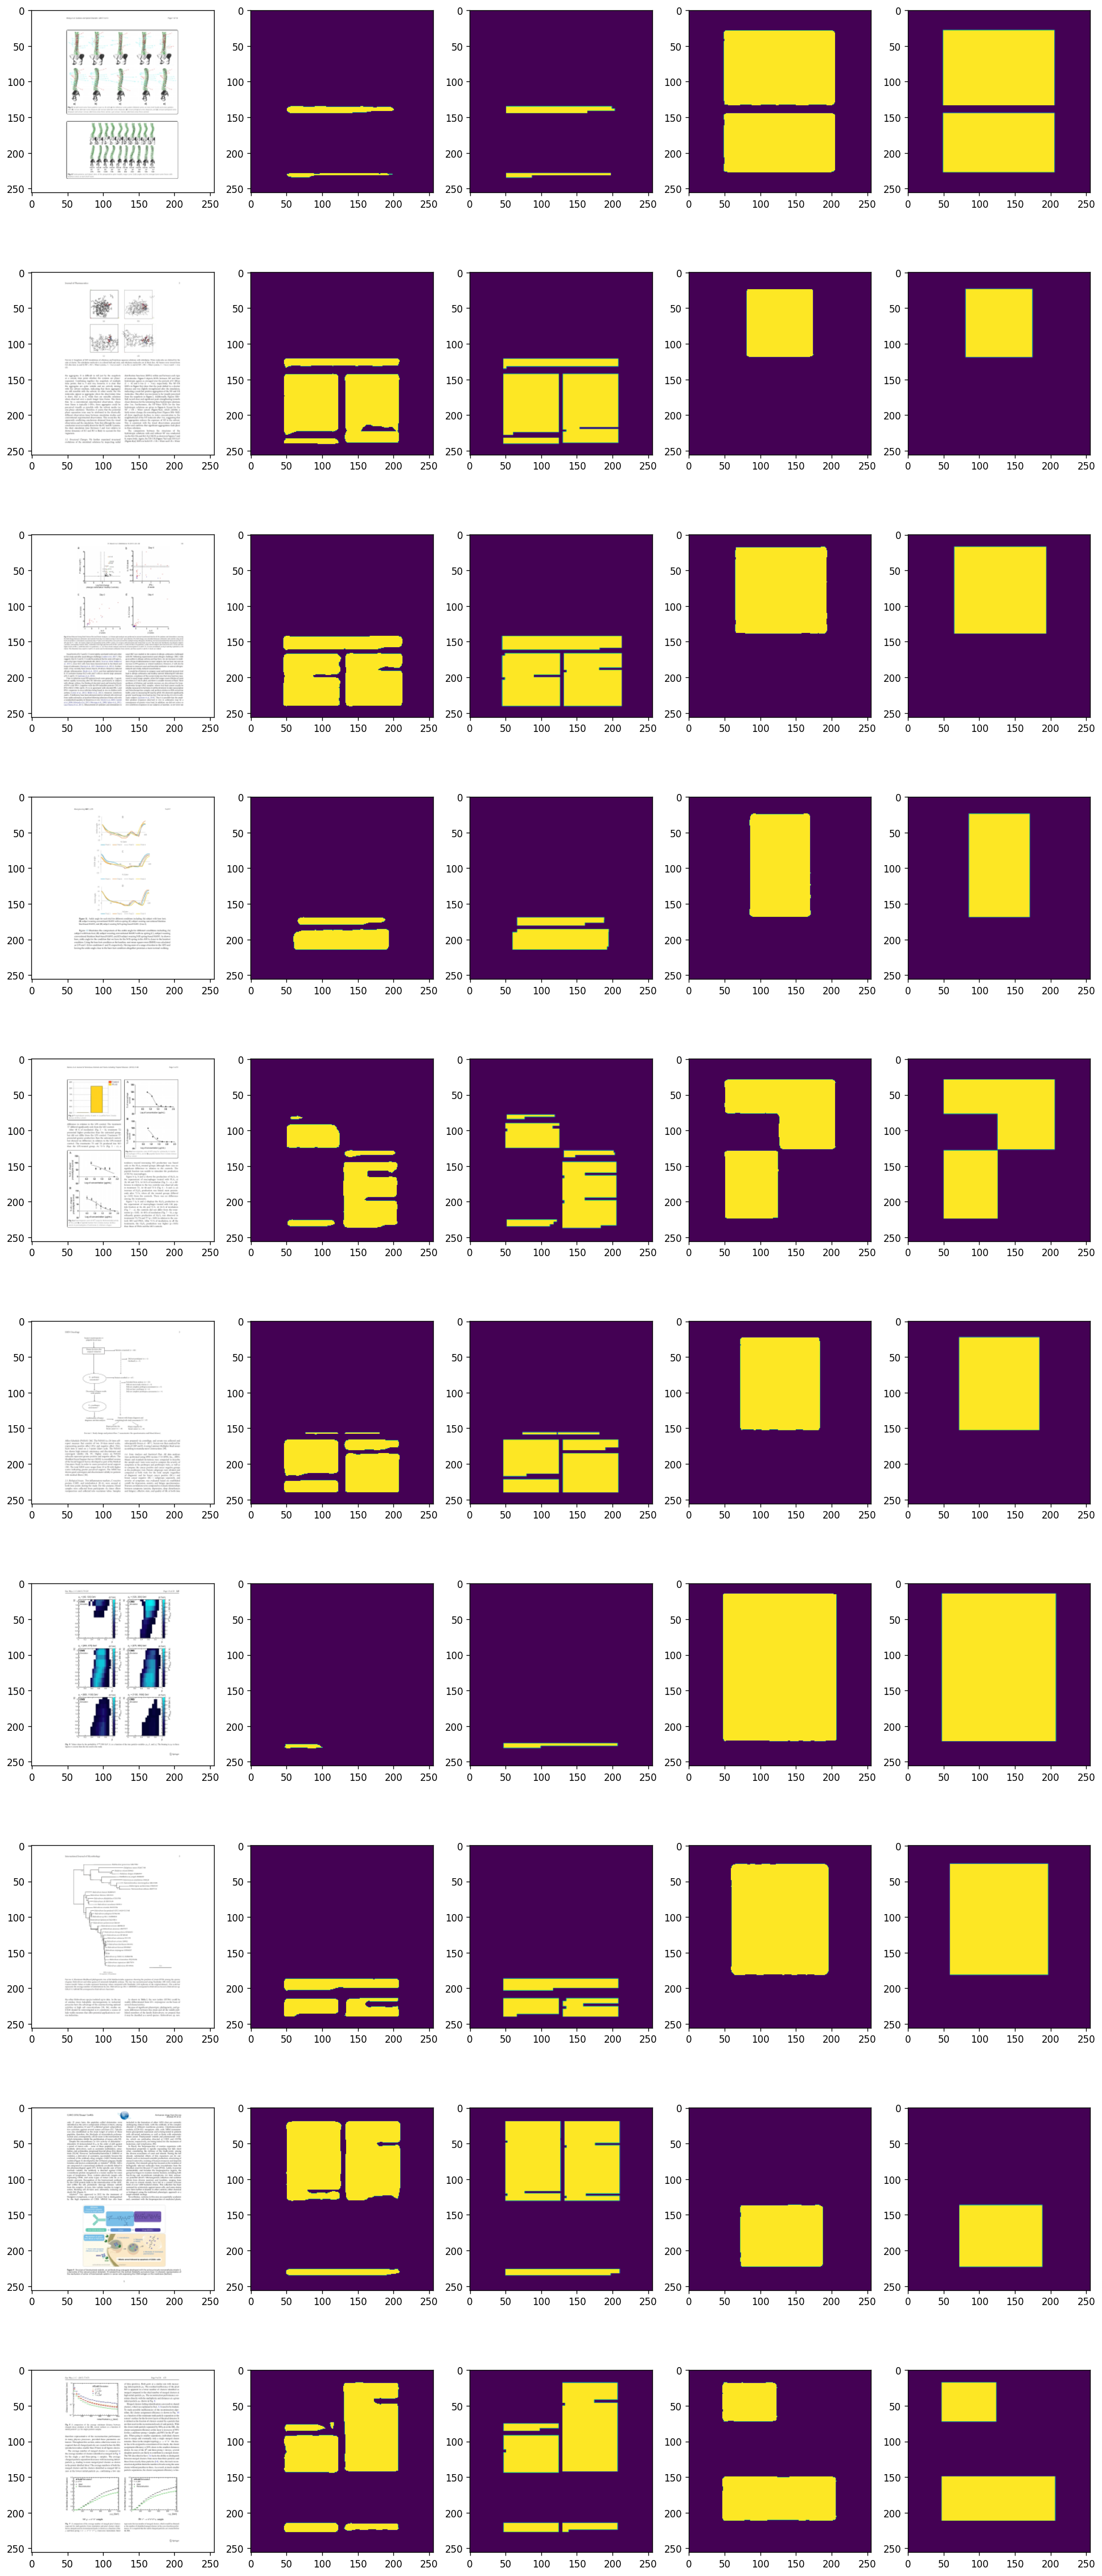

In [ ]:
train_dataloader1 = DataLoader(train_dataset, batch_size=1, num_workers=1,
                            pin_memory=True, shuffle=True, drop_last=False, worker_init_fn=seed_worker,   generator=g,)
validate_draw(model, train_dataloader1, device)  
